# Object masks in images from prompts with SAM 2

In [1]:
from mask_maker import *

import rawpy
import numpy as np
import matplotlib.pyplot as plt

In [2]:

GAMA = 1
MASK_DONE = False

obj_file_name = "biface"

dir_path = "./BDD/Reel/" + obj_file_name + "/"

path_S = dir_path + "Stray/all_off.cr2"
path_L = dir_path + "PS/LED17.cr2"
path_SL = dir_path + "PS&Stray/LED17.cr2"


using device: cpu
Mask saved to ./BDD/Reel/biface/PS&Stray\mask.png


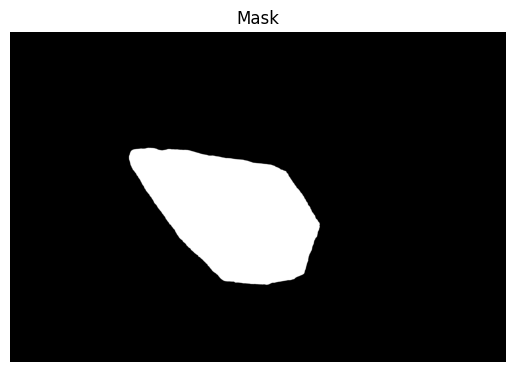

In [3]:
if MASK_DONE:
    MASK = Image.open(os.path.join(path_SL, "mask.png")).convert("L")
    MASK = np.array(MASK) / 255.0
else:
    MASK = make_just_one_mask(path_SL, "large")

plt.imshow(MASK, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()


In [4]:
def load_image_raw(path):
    """
    Charge une image RAW et retourne les données brutes du capteur
    sous forme de tableau numpy.
    """
    img = rawpy.imread(path)
    data_img = img.raw_image_visible.astype(np.float32)
    date_img_masked = data_img * MASK
    img.raw_image_visible[:, :] = date_img_masked.astype(np.uint16)
    return img


def diff_raw(raw_1, raw_2, res):
    data_1 = raw_1.raw_image_visible.astype(np.float32)
    data_2 = raw_2.raw_image_visible.astype(np.float32)

    diff = data_1 - data_2

    # On centre autour du niveau noir du capteur
    black = raw_1.black_level_per_channel[0]
    diff += black

    # Clip dans la dynamique 16 bits
    diff = np.clip(diff, 0, 65535)

    res.raw_image_visible[:, :] = diff.astype(np.uint16)

    return res


def show_raw_and_post(title, raw, bright=1):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title)

    raw_data = raw.raw_image_visible
    axes[0].imshow(raw_data, cmap='gray')
    axes[0].set_title("RAW brut (Bayer)")
    axes[0].axis("off")

    raw_rgb = raw.postprocess(
        use_auto_wb=True,
        bright = bright,
        no_auto_bright=True,
        gamma=(GAMA, GAMA),
        output_bps=16
    )
    raw_rgb = raw_rgb / (2**16-1)
    axes[1].imshow(raw_rgb)
    axes[1].set_title("Dématriçage postprocess")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

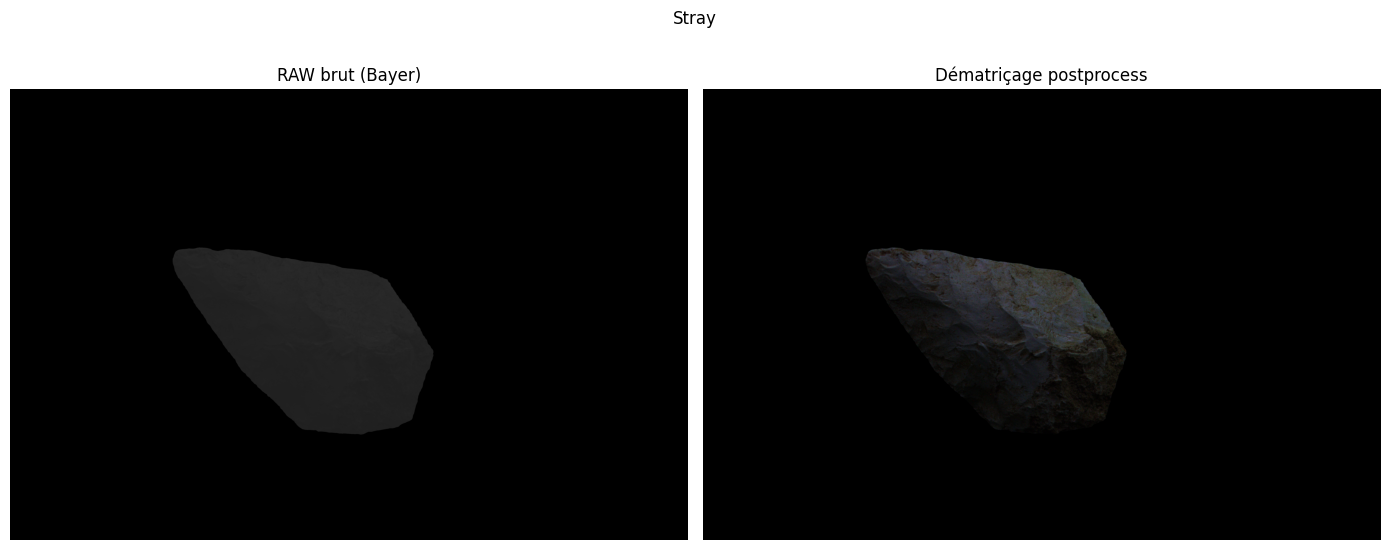

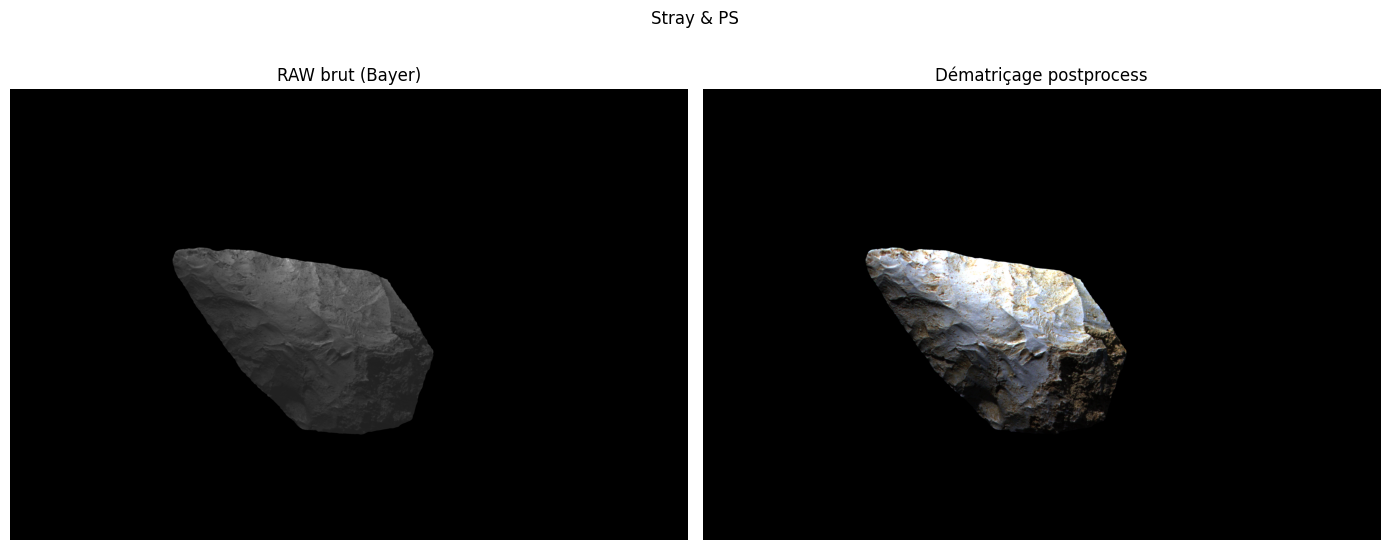

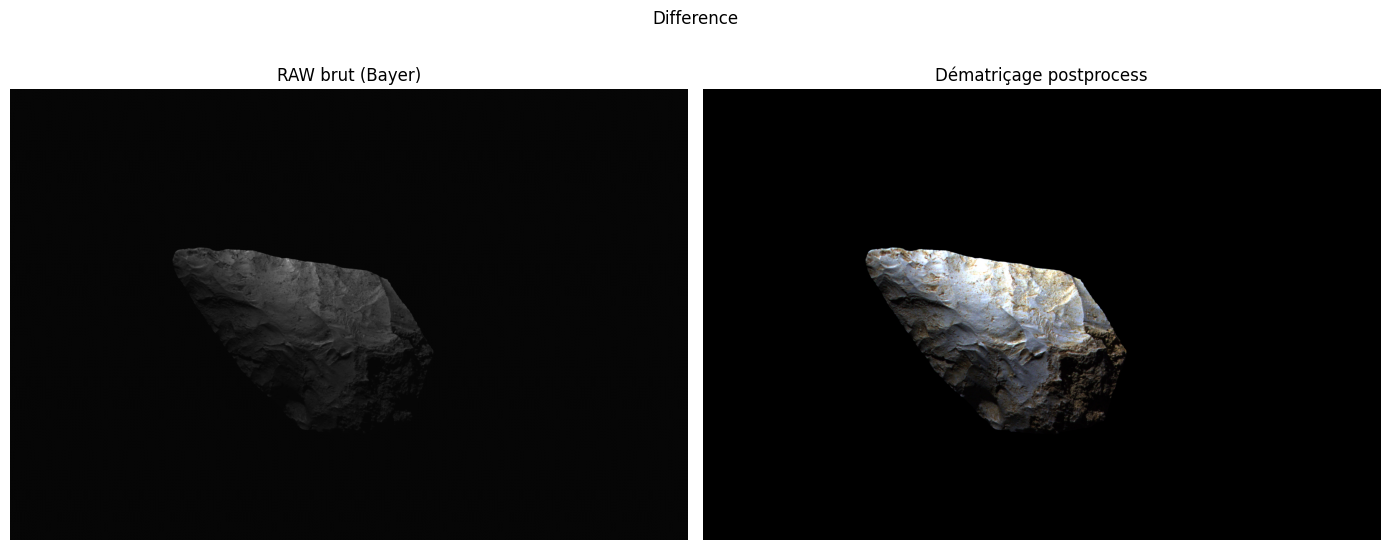

In [5]:
S = load_image_raw(path_S)
show_raw_and_post("Stray", S, 4)

SL = load_image_raw(path_SL)
show_raw_and_post("Stray & PS", SL, 2)

L_pred = load_image_raw(path_L)
L_pred = diff_raw(SL, S, L_pred)
show_raw_and_post("Difference", L_pred, 2)

In [ ]:
L_true = load_image_raw(path_L)
show_raw_and_post("PS", L_true, 2)

L_err = load_image_raw(path_L)
L_err = diff_raw(L_true, L_pred, L_err)
show_raw_and_post("Error", L_err, 2)

In [ ]:
#afficher L_true et L_pred à coté l'un de lautre pour comparer les détails et les différences
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Comparaison PS réel vs PS prédit")

rgb_0 = L_true.postprocess(
    use_auto_wb=True,
    no_auto_bright=True,
    gamma=(GAMA,GAMA),
    output_bps=16,
    bright = 2
)
rgb_0 = rgb_0 / (2**16-1)
axes[0].imshow(rgb_0)
axes[0].set_title("PS réel")
axes[0].axis("off")

rgb_1 = L_pred.postprocess(
    use_auto_wb=True,
    no_auto_bright=True,
    gamma=(GAMA,GAMA),
    output_bps=16,
    bright = 2
)
rgb_1 = rgb_1 / (2**16-1)
axes[1].imshow(rgb_1)
axes[1].set_title("PS prédit")
axes[1].axis("off")

plt.tight_layout()
plt.show()